# Enron Dataset Preprocessing : Format the dataset into time series

In this notebook, we format the parsed dataset into a multivariate time series.

## Step 1: Import libraries

In [14]:
import glob
import os
import pandas as pd

## Step 2: Preprocess the parsed dataset

The parsed dataset should first be generated from the previous notebook.

#### Load the data

In [2]:
df = pd.read_csv('enron_dataset_raw.csv', encoding='utf-8', index_col=0)

print(df.shape) # Shape: (517401, 13)

(517401, 12)


,user,From,To,date,timestamp,file
0,allen-p,christi.nicolay@enron.com,phillip.allen@enron.com,"Tue, 12 Dec 2000 04:41:00 -0800 (PST)",976624860.0,allen-p/notes_inbox/36.
1,allen-p,yild@zdemail.zdlists.com,pallen@enron.com,"Wed, 13 Dec 2000 08:11:00 -0800 (PST)",976723860.0,allen-p/notes_inbox/19.
2,allen-p,lisa.jacobson@enron.com,"lisa.jacobson@enron.com, kevin.mcgowan@enron.c...","Thu, 10 May 2001 06:05:00 -0700 (PDT)",989499900.0,allen-p/notes_inbox/50.


#### Filter columns

In [7]:
df = df[['user', 'From', 'To', 'date', 'file', 'timestamp']]
df.head(3)

,user,From,To,date,file,timestamp
0,allen-p,christi.nicolay@enron.com,phillip.allen@enron.com,"Tue, 12 Dec 2000 04:41:00 -0800 (PST)",allen-p/notes_inbox/36.,976624860.0
1,allen-p,lisa.jacobson@enron.com,"lisa.jacobson@enron.com, kevin.mcgowan@enron.c...","Thu, 10 May 2001 06:05:00 -0700 (PDT)",allen-p/notes_inbox/50.,989499900.0
2,allen-p,rebecca.cantrell@enron.com,"stephanie.miller@enron.com, ruth.concannon@enr...","Wed, 13 Dec 2000 08:22:00 -0800 (PST)",allen-p/notes_inbox/9.,976724520.0


#### Remove invalid emails

Remove invalid emails with missing `From`/`To` field.

In [4]:
valid_msg_mask = ~df.From.isnull() & ~df.To.isnull()
print(f"{sum(valid_msg_mask)} messages ({100*sum(valid_msg_mask)/len(valid_msg_mask):.1f}%) have valid fields.")
df = df[valid_msg_mask]
df = df.reset_index(drop=True)

495554 messages (95.8%) have valid fields.


#### Remove sent from outside Enron

Remove emails From emails outside of `@enron.com`.

In [5]:
valid_msg_mask = df.From.apply(lambda s: '@enron.com' in s)
print(f"{sum(valid_msg_mask)} messages ({100*sum(valid_msg_mask)/len(valid_msg_mask):.1f}%) have valid fields.")
df = df[valid_msg_mask]
df = df.reset_index(drop=True)

410603 messages (82.9%) have valid fields.


#### Split emails by receivers

Split emails `To` fields into separate emails. This is necessary to subsequently group them by receiver address.

In [10]:
def split_to_field(row):
    addr_list = row.To.split(',')
    data = list()
    for i, addr in enumerate(addr_list):
        addr = addr.strip()
        clean_row = row.copy()
        clean_row['To'] = addr
        data.append(clean_row)
    return data

In [11]:
# Process the messages by chunk in a separate and save each chunk (to avoid memory issues)
data = list()
chunk_idx = 0
tot_count = 0

for i, row in df.iterrows():
    data.extend(split_to_field(row))
    
    # Save chunk
    if ((i+1) % 10000) == 0:
        tot_count += len(data)
        print(f"\rIter {i+1:,d}/{len(df):,d}: {tot_count:,d} emails processed", end="")
        
        # Save chunk to file
        clean_df = pd.DataFrame(data)
        clean_df.to_csv(f'enron_dataset_splitted_receivers_{chunk_idx:d}.csv', encoding='utf-8')
        chunk_idx += 1
        
        # Reset data
        data = list()
print()

Iter 510,000/410,603: 2,587,300 emails processed


In [ ]:
del df  # Delete raw dataframe to free up memory

Merge all chunks

In [20]:
all_data = []
for file in glob.glob('enron_dataset_splitted_receivers_*.csv'):
    chunk_df = pd.read_csv(file, encoding='utf-8', index_col=0)
    chunk_df = chunk_df[['user', 'From', 'To', 'date', 'file', 'timestamp']]
    all_data.append(chunk_df)
    
clean_df = pd.concat(all_data)
clean_df = clean_df.sort_values(by=['To', 'timestamp'])
clean_df = clean_df.reset_index(drop=True)

Final cleaning step: Remove a few bogus email dated in 1979.

In [63]:
from datetime import datetime
from pytz import timezone
clean_df['date'] = pd.to_datetime(clean_df['date'])
clean_df = clean_df.loc[clean_df.date > datetime(2000, 1, 1, tzinfo=timezone('US/Pacific'))]
print(clean_df.shape)

Move timestamp origin to Jan 1, 2000.

In [83]:
print('First email sent:', clean_df['date'].min())
print('Last emil sent:', clean_df['date'].max())

orig_timestamp = datetime(2000, 1, 1, 0, 0, 0, tzinfo=timezone('US/Pacific')).timestamp()
clean_df['timestamp'] -= orig_timestamp

# Show stats of timestamps in days (max should be around 923 days ~ 2.5 yeas)
(clean_df['timestamp'] / (3600 * 24)).describe()

First email sent: 2000-01-01 06:36:00-08:00
Last emil sent: 2002-07-12 04:36:00-07:00


count    2.554822e+06
mean     4.594968e+02
std      1.837847e+02
min      2.798611e-01
25%      3.313931e+02
50%      4.544507e+02
75%      6.395620e+02
max      9.231549e+02
Name: timestamp, dtype: float64

Remove duplicates (due to copied emails in several folders in the raw dataset)

In [31]:
index_with_duplicated = clean_df[['To', 'timestamp']].drop_duplicates().index
clean_df = clean_df.loc[index_with_duplicated]
print(clean_df.shape)

(844680, 6)


Save the clean dataframe

In [33]:
clean_df = clean_df[['user', 'From', 'To', 'date', 'file', 'timestamp']]

DATA_DIR = '../../../data/enron/'

# Save to csv with header
clean_df.to_csv(os.path.join(DATA_DIR, 'enron_dataset_splitted_receivers.csv'), encoding='utf-8')

# Save it without header/index in .csv.gz to match format for tsvar.preprocessing.Dataset
clean_df[['From', 'To', 'timestamp']].to_csv(os.path.join(DATA_DIR, 'enron_dataset_splitted_receivers.csv.gz'), 
                                             encoding='utf-8', header=False, index=False, 
                                             compression='gzip')

## Step 3: Quick Exploration

In [15]:
from matplotlib import pyplot as plt
%matplotlib inline

In [35]:
DATA_DIR = '../../../data/enron/'

#### Investigate the whole dataset

In [36]:
clean_df = pd.read_csv(os.path.join(DATA_DIR, 'enron_dataset_splitted_receivers.csv'), encoding='utf-8', index_col=0)

Quick look at the data

In [37]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844680 entries, 0 to 2587299
Data columns (total 6 columns):
user         844680 non-null object
From         844680 non-null object
To           844680 non-null object
date         844680 non-null object
file         844680 non-null object
timestamp    844680 non-null float64
dtypes: float64(1), object(5)
memory usage: 45.1+ MB


In [38]:
clean_df.head()

,user,From,To,date,file,timestamp
0,arnold-j,a..roberts@enron.com,#2.martin@enron.com,2001-10-11 07:25:19-07:00,arnold-j/deleted_items/356.,56097139.0
4,arnold-j,a..roberts@enron.com,#2.martin@enron.com,2001-11-17 06:59:24-08:00,arnold-j/deleted_items/768.,59295984.0
18,arnold-j,a..roberts@enron.com,#2.martin@enron.com,2001-11-18 06:03:52-08:00,arnold-j/deleted_items/618.,59379052.0
32,kaminski-v,a..roberts@enron.com,#2.martin@enron.com,2002-01-18 05:21:12-08:00,kaminski-v/deleted_items/344.,64646892.0
35,saibi-e,bob.ambrocik@enron.com,#23.training@enron.com,2001-09-28 15:03:25-07:00,saibi-e/inbox/527.,55001425.0


In [39]:
clean_df.timestamp.min()

24180.0

In [40]:
clean_df.timestamp.max()

79760580.0

Group by receiver to generate temporal point process

In [41]:
tpp_df = clean_df.groupby('To').agg({'From': list, 'timestamp': list})

In [42]:
tpp_df['Count'] = tpp_df.From.apply(len)

Histogram of number of emails received per user

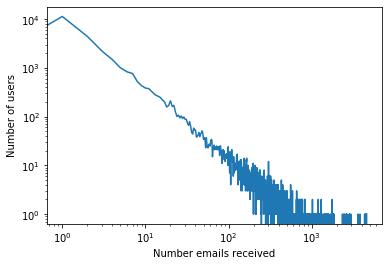

In [43]:
y = np.bincount(tpp_df['Count'])
x = np.arange(len(y))

plt.loglog(x,y)
plt.xlabel('Number emails received')
plt.ylabel('Number of users');

#### Investigate top-100 dataset

In [44]:
from tsvar.preprocessing import Dataset
dataset = Dataset(path=os.path.join(DATA_DIR, 'enron_dataset_splitted_receivers.csv.gz'), top=100, timescale='median')

Number of users

In [45]:
dataset.dim

100

Number of messages

In [46]:
sum(map(len, dataset.timestamps))

51060

In [47]:
min(map(len, dataset.timestamps))

7

In [48]:
max(map(len, dataset.timestamps))

3527

Histogram of number of emails received per user

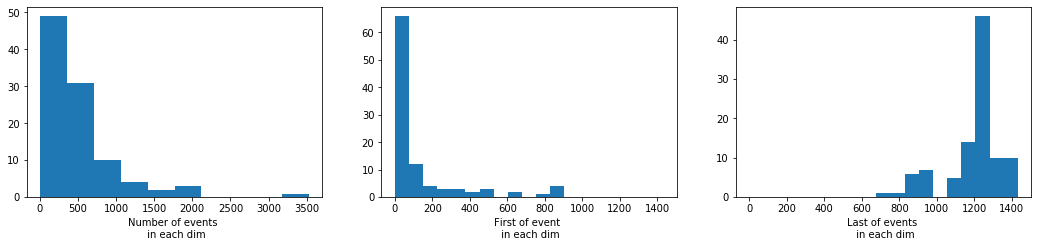

In [49]:
fig, axs = plt.subplots(1, 3, figsize=(18, 3.5))

axs[0].hist(list(map(len, dataset.timestamps)))
axs[0].set_xlabel('Number of events \n in each dim')

end_time = max(map(max, dataset.timestamps))
axs[1].hist(list(map(min, dataset.timestamps)), bins=np.linspace(0, end_time, 20))
axs[1].set_xlabel('First of event \n in each dim')

axs[2].hist(list(map(max, dataset.timestamps)), bins=np.linspace(0, end_time, 20))
axs[2].set_xlabel('Last of events \n in each dim');